In [251]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.initializers import RandomNormal, RandomUniform, TruncatedNormal, Zeros, Ones, GlorotNormal, GlorotUniform, Identity, Orthogonal, Constant, VarianceScaling

***
# Data Collection and Preprocessing

Use the yfinance API to fetch the historical stock data for the 30 stocks in the Dow Jones Industrial Average (DJIA) from 1996 to August 2024, and save the data to a CSV file for later use,

In [176]:
import yfinance as yf
# Tickers of the 30 stocks in the Dow Jones Industrial Average (as of 2024)
djia_symbols = [
    'UNH','MSFT','GS','HD','CAT','CRM','MCD','AMGN','V','TRV','AXP','BA','HON','IBM','JPM','AAPL','AMZN','JNJ','PG','CVX','MRK','DIS','NKE','MMM','KO','WMT','DOW','CSCO','INTC','VZ'
]
# Date range
start_date = '1996-01-01'
end_date = '2024-8-31'

all_data = pd.DataFrame()
# Download historical data for each stock
for symbol in djia_symbols:
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    stock_data['Ticker'] = symbol  # Add the stock ticker column
    all_data = pd.concat([all_data, stock_data])
# Save the data to a CSV file
all_data.to_csv('DJIA_data.csv')
# Print the first few rows of data for verification
print(all_data.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

                Open      High       Low     Close  Adj Close   Volume Ticker
Date                                                                         
1996-01-02  8.125000  8.125000  8.000000  8.078125   6.434171  7608800    UNH
1996-01-03  8.093750  8.156250  7.984375  8.109375   6.459061  8917600    UNH
1996-01-04  8.125000  8.187500  8.031250  8.187500   6.521289  6700800    UNH
1996-01-05  8.156250  8.156250  7.781250  7.859375   6.259940  9153600    UNH
1996-01-08  7.859375  7.859375  7.671875  7.703125   6.135488  1856800    UNH


## Data Preprocessing

In [177]:
# Load the current Dataset just saved
df = pd.read_csv('DJIA_data.csv')

查看数据信息，确认数据成分

In [178]:
# 1. Dataset description
print("The dataset contains the following columns:", df.columns)

# 2. Date range
start_date = df['Date'].min()
end_date = df['Date'].max()
print(f"Dataset Date Range: from {start_date} to {end_date}")

# 3. Number of stocks
stock_count = df['Ticker'].nunique()
print(f"Number of stocks in the Dataset: {stock_count}")

# 4. Total number of records
total_records = df.shape[0]
print(f"Total number of records in the Dataset: {total_records}")

The dataset contains the following columns: Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Ticker'],
      dtype='object')
Dataset Date Range: from 1996-01-02 to 2024-08-30
Number of stocks in the Dataset: 30
Total number of records in the Dataset: 204241


In [179]:
# Count the number of data days for each stock by ticker symbol
stock_days_info = df.groupby('Ticker')['Date'].count().reset_index()

# Rename the column names
stock_days_info.columns = ['Ticker', 'days_of_data']

# Display the number of data days for each stock
print(stock_days_info)

   Ticker  days_of_data
0    AAPL          7216
1    AMGN          7216
2    AMZN          6869
3     AXP          7216
4      BA          7216
5     CAT          7216
6     CRM          5083
7    CSCO          7216
8     CVX          7216
9     DIS          7216
10    DOW          1373
11     GS          6374
12     HD          7216
13    HON          7216
14    IBM          7216
15   INTC          7216
16    JNJ          7216
17    JPM          7216
18     KO          7216
19    MCD          7216
20    MMM          7216
21    MRK          7216
22   MSFT          7216
23    NKE          7216
24     PG          7216
25    TRV          7216
26    UNH          7216
27      V          4142
28     VZ          7216
29    WMT          7216


After checking the number of data days in the dataset, there is a significantly low number of days for DOW (only 1,373 days). This could be because the DOW stock joined the DJIA in recent years.
To reduce any instability, we have chosen to remove this stock and proceed with the remaining 29 stocks for subsequent model training

In [180]:
# Remove all data where the Ticker is 'DOW'
df = df[df['Ticker'] != 'DOW']

# Count the number of data days for each stock by ticker symbol to verify 'DOW' has been removed
stock_days_info_updated = df.groupby('Ticker')['Date'].count().reset_index()
stock_days_info_updated.columns = ['Ticker', 'days_of_data']

# Display the updated number of data days for each stock
print(stock_days_info_updated)

# 3. Number of stocks
stock_count = df['Ticker'].nunique()
print(f"Number of stocks in the dataset: {stock_count}")

   Ticker  days_of_data
0    AAPL          7216
1    AMGN          7216
2    AMZN          6869
3     AXP          7216
4      BA          7216
5     CAT          7216
6     CRM          5083
7    CSCO          7216
8     CVX          7216
9     DIS          7216
10     GS          6374
11     HD          7216
12    HON          7216
13    IBM          7216
14   INTC          7216
15    JNJ          7216
16    JPM          7216
17     KO          7216
18    MCD          7216
19    MMM          7216
20    MRK          7216
21   MSFT          7216
22    NKE          7216
23     PG          7216
24    TRV          7216
25    UNH          7216
26      V          4142
27     VZ          7216
28    WMT          7216
Number of stocks in the dataset: 29


In [181]:
print("Dataset columns：", df.columns)
# Total number of records
total_records = df.shape[0]
print(f"Total number of records in the new Dataset: {total_records}")

Dataset columns： Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'Ticker'],
      dtype='object')
Total number of records in the new Dataset: 202868


By converting the 'Date' column to datetime, we ensure that Python correctly interprets and handles this data for further operations.
After converting the 'Date' column to datetime, we set it as the index of the DataFrame.
Transforms the DataFrame into a structure that is more suited for time-series analysis and visualization, making it easier to work with time-specific operations.

In [182]:
# Convert 'Date' column to datetime 
df['Date'] = pd.to_datetime(df['Date'])
# Set 'Date' as the index
df.set_index('Date', inplace=True)

***
## Data Analysis by plotting graphs

### Plotting the Cumulative Return graphs for the dataset

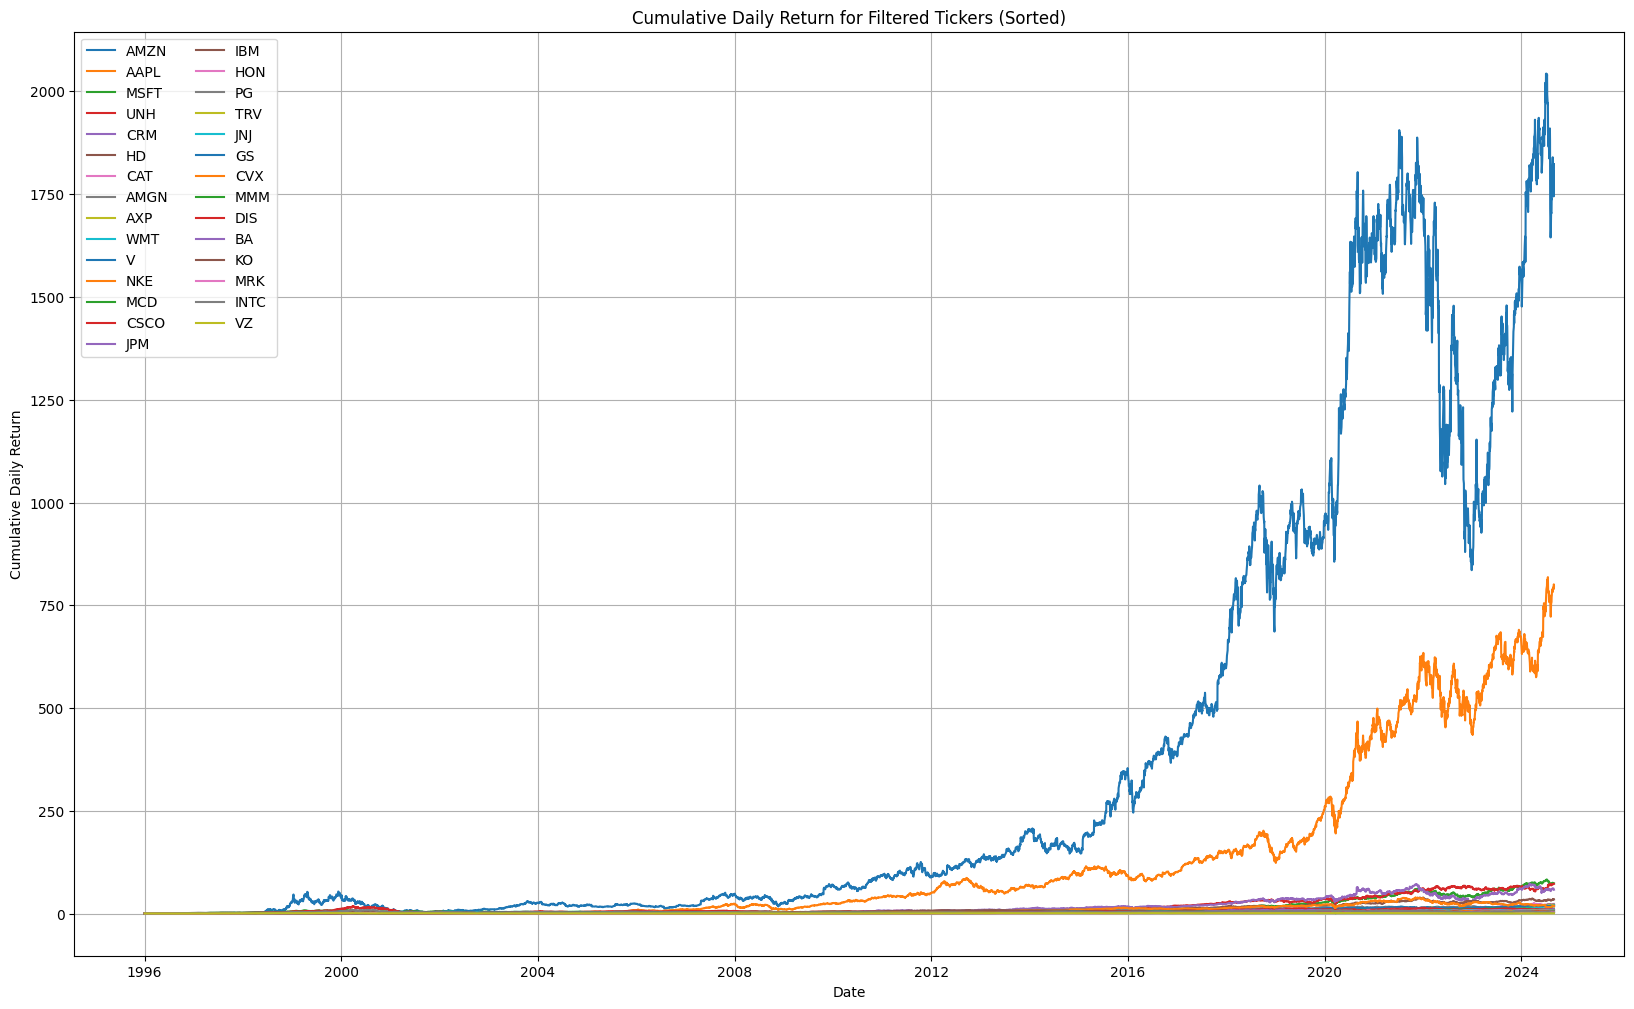

In [183]:
# Calculate daily returns
df['Daily_Return'] = df.groupby('Ticker')['Close'].pct_change()

# Calculate cumulative daily returns (starting from 1)
df['Cumulative_Daily_Return'] = (1 + df['Daily_Return']).groupby(df['Ticker']).cumprod()

# Find unique stock tickers in the dataset
tickers_filtered = df['Ticker'].unique()

# Calculate the last cumulative return for each ticker
final_cumulative_returns = df.groupby('Ticker')['Cumulative_Daily_Return'].last()

# Sort stocks based on the final cumulative returns
sorted_tickers = final_cumulative_returns.sort_values(ascending=False).index

# Plot cumulative daily return curves for each stock
plt.figure(figsize=(20, 12))
for ticker in sorted_tickers:
    stock_data = df[df['Ticker'] == ticker]
    plt.plot(stock_data.index, stock_data['Cumulative_Daily_Return'], label=ticker)

plt.title('Cumulative Daily Return for Filtered Tickers (Sorted)')
plt.xlabel('Date')
plt.ylabel('Cumulative Daily Return')
plt.legend(loc='upper left', ncol=2)  
plt.grid(True)
plt.show()

Plotting the Cumulative Montly return graph

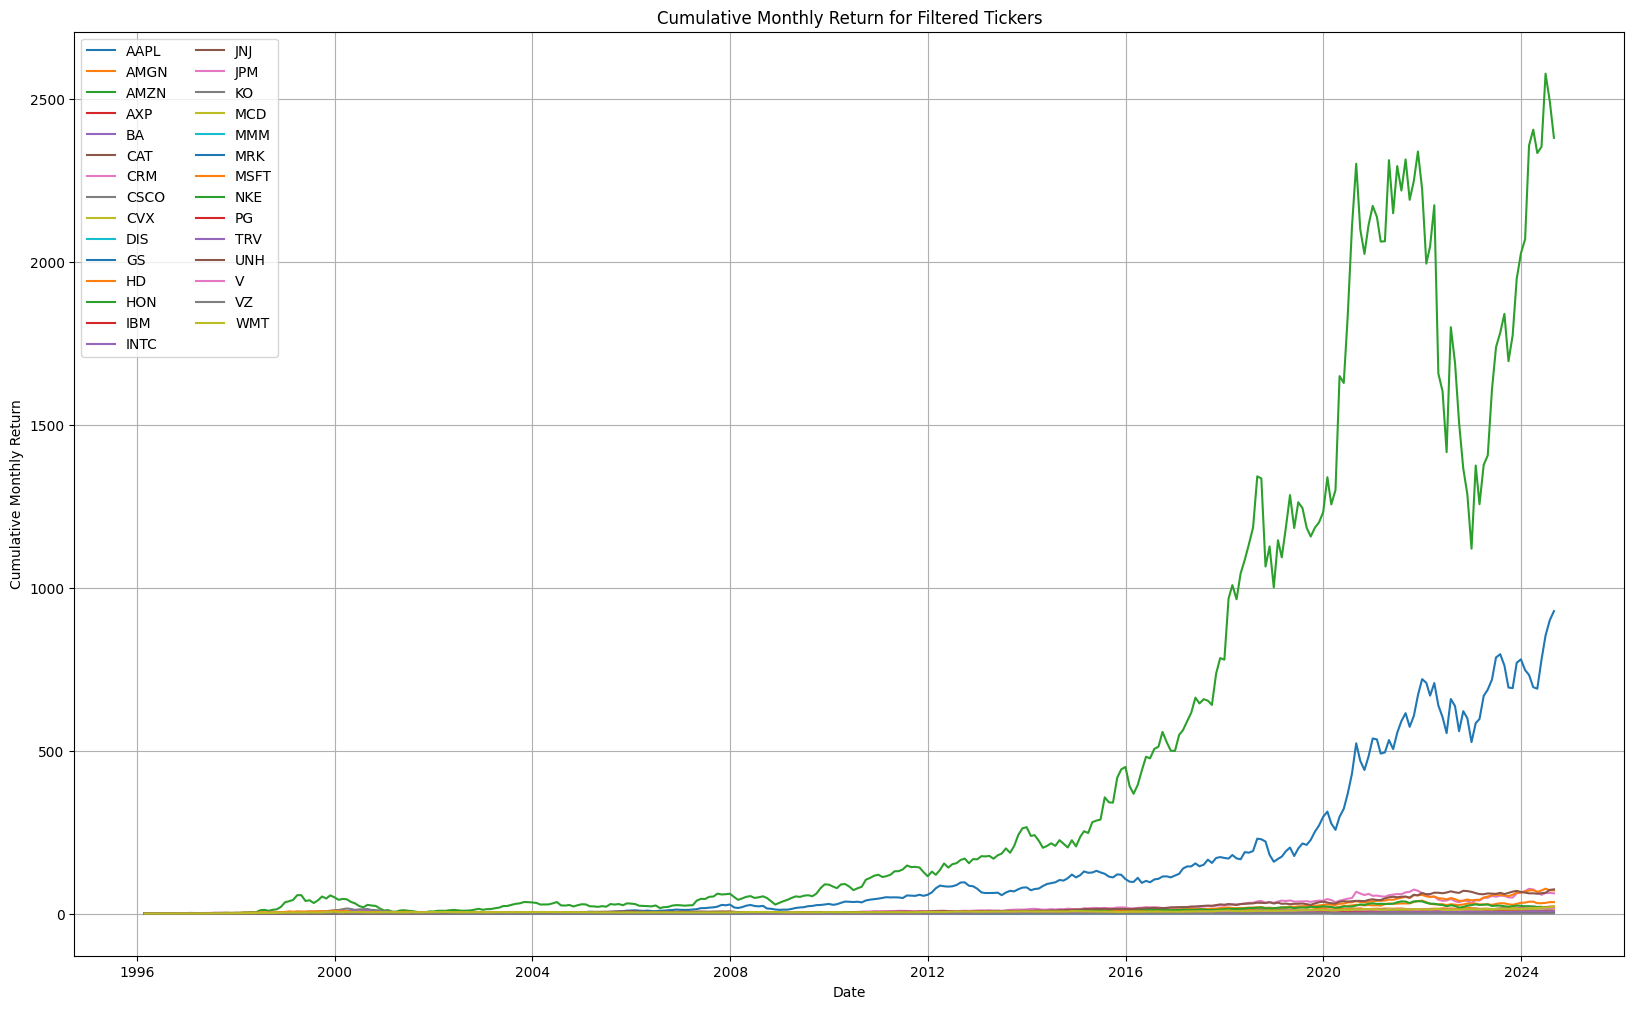

In [184]:
# Resample data to monthly frequency and calculate the last closing price of each month
df_monthly = df.groupby('Ticker')['Close'].resample('ME').last().reset_index()

# Calculate monthly returns (percentage change from the previous month)
df_monthly['Monthly_Return'] = df_monthly.groupby('Ticker')['Close'].pct_change()

# Calculate cumulative monthly returns (starting from 1)
df_monthly['Cumulative_Monthly_Return'] = (1 + df_monthly['Monthly_Return']).groupby(df_monthly['Ticker']).cumprod()

# Set the 'Date' as the index for the monthly data
df_monthly['Date'] = pd.to_datetime(df_monthly['Date'])
df_monthly.set_index('Date', inplace=True)

# Find unique stock tickers again
tickers_filtered = df_monthly['Ticker'].unique()

# Plot cumulative monthly return curves for each stock
plt.figure(figsize=(20, 12))
for ticker in tickers_filtered:
    stock_data = df_monthly[df_monthly['Ticker'] == ticker]
    plt.plot(stock_data.index, stock_data['Cumulative_Monthly_Return'], label=ticker)

plt.title('Cumulative Monthly Return for Filtered Tickers')
plt.xlabel('Date')
plt.ylabel('Cumulative Monthly Return')
plt.legend(loc='upper left', ncol=2)
plt.grid(True)
plt.show()

In [185]:
# print("数据集包含以下列：", df.columns )


### Calculate each Stock's Trading Volume Percentage

In [186]:
# Group by Ticker and calculate total trading volume
ticker_volume = df.groupby('Ticker')['Volume'].sum()

# Calculate the trading volume percentage for each stock
ticker_percentage = (ticker_volume / ticker_volume.sum()) * 100

# Create a DataFrame to store each stock's trading volume and its percentage
all_ticker_data = pd.DataFrame({
     'Ticker': ticker_volume.index,
     'Volume': ticker_volume.values,
     'Percentage': ticker_percentage.values
})

# Save all stock trading volume and percentage information to an Excel file
output_file = 'all_tickers_volume_percentage.xlsx'
all_ticker_data.to_excel(output_file, index=False)
print("\n All tickers volume percentage has been stored in {} \n".format(output_file))



 All tickers volume percentage has been stored in all_tickers_volume_percentage.xlsx 


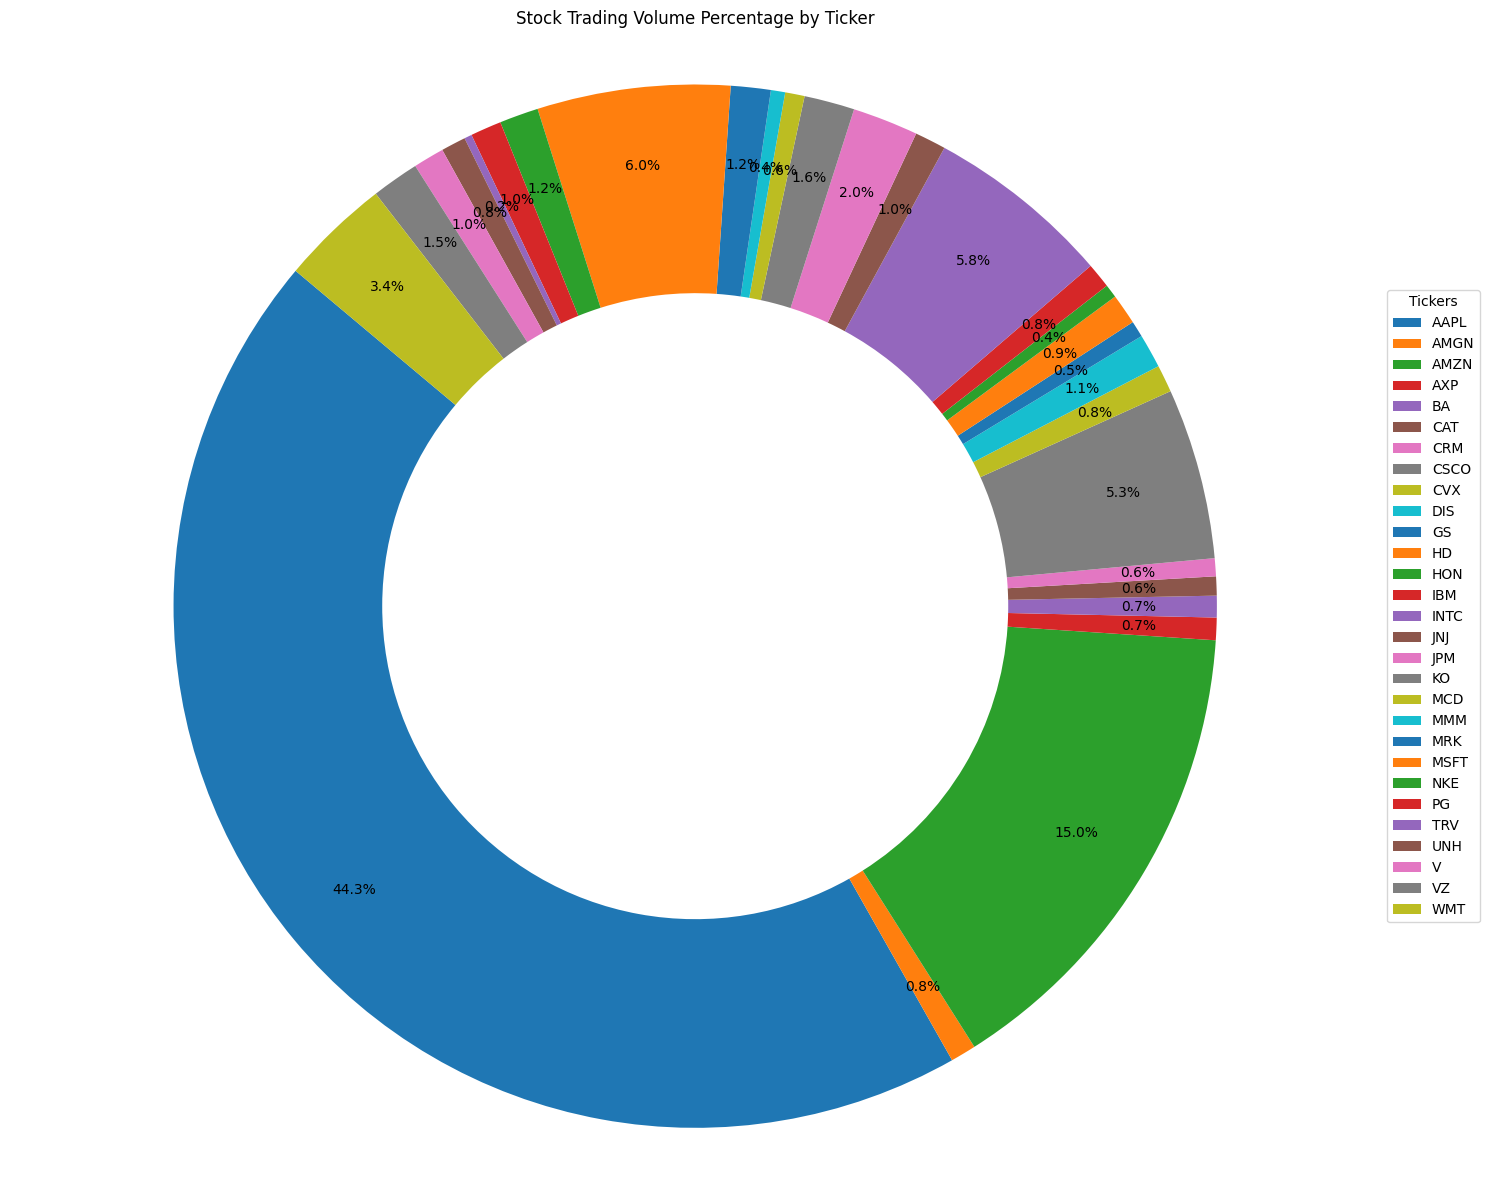

In [187]:
# Plotting the pie chart with labels outside
plt.figure(figsize=(15, 12))

# Create a pie chart with ticker labels outside
plt.pie(
    all_ticker_data['Percentage'], 
    labels=None,  # Remove default labels
    autopct='%1.1f%%', 
    startangle=140, 
    wedgeprops=dict(width=0.4), # Adjust the wedge size to make space for labels
    pctdistance=0.85,  # Distance of percentage labels from the center
)

# Add labels outside the pie chart using ticker symbols with connector lines
plt.legend(
    all_ticker_data['Ticker'], 
    loc='center left', 
    bbox_to_anchor=(1, 0.5), 
    title='Tickers'
)

# Set the aspect ratio to be equal so that pie is drawn as a circle
plt.axis('equal')

# Title of the pie chart
plt.title('Stock Trading Volume Percentage by Ticker')

# Display the chart
plt.tight_layout()
plt.show()

***
## Dataset Feature Engineering,labeling

Calculate Daily Return, and classify the data and assign labels of 1 and 0.

In [188]:
df.reset_index(inplace=True)

# Sort by 'Ticker' and 'Date'
df_filtered = df.sort_values(by=['Ticker', 'Date'])

# Remove rows with missing values (if any)
df_filtered = df_filtered.dropna(subset=['Daily_Return'])

# Pivot the data to have one column per stock with its daily return
df_filtered = df_filtered.pivot(index='Date', columns='Ticker', values='Daily_Return')

# Calculate daily return's median value
df_filtered['Median'] = df_filtered.median(axis=1)

# Lable each Stock (1 if return > median, 0 otherwise)
for ticker in df_filtered.columns:
    if ticker != 'Median':  # 排除中位数列
        df_filtered[f'label_{ticker}'] = (df_filtered[ticker] > df_filtered['Median']).astype(int)

df_filtered.reset_index(inplace=True)

# Save the processed data to a CSV file
df_filtered.to_csv('PreP_DJIA_data_01.csv', index=False)

df_filtered.head()


Ticker,Date,AAPL,AMGN,AMZN,AXP,BA,CAT,CRM,CSCO,CVX,...,label_MMM,label_MRK,label_MSFT,label_NKE,label_PG,label_TRV,label_UNH,label_V,label_VZ,label_WMT
0,1996-01-03,0.000000,-0.010730,NaN,0.000000,-0.009390,0.016807,NaN,-0.039280,0.002364,...,0,0,0,0,1,1,1,0,1,1
1,1996-01-04,-0.017509,-0.043384,NaN,-0.009036,-0.025276,-0.008264,NaN,-0.037479,0.028302,...,1,1,1,0,1,1,1,0,0,1
2,1996-01-05,0.085150,0.022676,NaN,-0.003040,0.017828,0.016667,NaN,0.012389,0.016055,...,1,0,0,0,1,1,0,0,1,0
3,1996-01-08,0.010948,-0.016630,NaN,0.000000,0.022293,-0.004098,NaN,-0.009615,0.004515,...,0,1,0,1,1,1,0,0,0,0
4,1996-01-09,-0.054151,-0.023675,NaN,-0.015244,-0.011098,-0.026749,NaN,-0.076787,0.003933,...,1,1,0,0,1,1,0,0,1,0


In [189]:
# print("数据集包含以下列：", df_filtered.shape)

数据集包含以下列： (7215, 60)


## Dataset Definition and Setup

In [232]:
stock_columns = [col for col in df_filtered.columns if col not in ['Date', 'Median'] and not col.startswith('label_')]
label_columns = [col for col in df_filtered.columns if col.startswith('label_')]

all_trainX, all_trainY, all_testX, all_testY = [], [], [], []

look_back = 30  
train_ratio = 0.8  # 80% as training set, 20% as testing set
# Iterate through each stock column and its corresponding label column
for stock_col, label_col in zip(stock_columns, label_columns):
    # Extract daily returns and labels for the stock, and remove rows with missing values
    stock_data = df_filtered[[stock_col, label_col]].dropna()

    # Extract daily returns for the stock as the dataset
    dataset = stock_data[stock_col].values.reshape(-1, 1)

    # Standardize the dataset
    scaler = MinMaxScaler(feature_range=(0, 1))
    dataset = scaler.fit_transform(dataset)

    # Extract the label column
    labels = stock_data[label_col].values

    # Split the dataset into training and testing sets
    train_size = int(len(dataset) * train_ratio)
    train, test = dataset[:train_size], dataset[train_size:]
    train_labels, test_labels = labels[:train_size], labels[train_size:]

    # Define the create_dataset function to generate input sequences and target values
    def create_dataset(datas, labels, lookb):
        datax, datay = [], []
        for i in range(len(datas) - lookb - 1):
            a = datas[i:(i + lookb), 0]  # Input sequence
            datax.append(a)
            datay.append(labels[i + lookb])  # Target value
        return np.array(datax), np.array(datay)

    # Create inputs and outputs for training and testing sets
    trainX, trainY = create_dataset(train, train_labels, look_back)
    testX, testY = create_dataset(test, test_labels, look_back)

    # Reshape the data [number of samples, time steps, number of features]
    trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
    testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

    # Save the training and testing sets for each stock
    all_trainX.append(trainX)
    all_trainY.append(trainY)
    all_testX.append(testX)
    all_testY.append(testY)

    # Output the size of the training and testing sets for each stock
    print(f"{stock_col} - Training set size: {trainX.shape[0]}, Testing set size: {testX.shape[0]}")

# Combine the training and testing sets for all stocks
combined_trainX = np.concatenate(all_trainX)
combined_trainY = np.concatenate(all_trainY)
combined_testX = np.concatenate(all_testX)
combined_testY = np.concatenate(all_testY)

# Output the size of the combined training and testing sets
print(f"Combined Training set size: {combined_trainX.shape[0]}, Combined Testing set size: {combined_testX.shape[0]}")

AAPL - Training set size: 5741, Testing set size: 1412
AMGN - Training set size: 5741, Testing set size: 1412
AMZN - Training set size: 5463, Testing set size: 1343
AXP - Training set size: 5741, Testing set size: 1412
BA - Training set size: 5741, Testing set size: 1412
CAT - Training set size: 5741, Testing set size: 1412
CRM - Training set size: 4034, Testing set size: 986
CSCO - Training set size: 5741, Testing set size: 1412
CVX - Training set size: 5741, Testing set size: 1412
DIS - Training set size: 5741, Testing set size: 1412
GS - Training set size: 5067, Testing set size: 1244
HD - Training set size: 5741, Testing set size: 1412
HON - Training set size: 5741, Testing set size: 1412
IBM - Training set size: 5741, Testing set size: 1412
INTC - Training set size: 5741, Testing set size: 1412
JNJ - Training set size: 5741, Testing set size: 1412
JPM - Training set size: 5741, Testing set size: 1412
KO - Training set size: 5741, Testing set size: 1412
MCD - Training set size: 574

In [233]:
# combined_testX.shape

# Training and Testing Bidirectional LSTM Models with Multiple Initializers and Weighted Voting

In [234]:
# Initializers list
initializers = {
    'RandomNormal': RandomNormal(mean=0.0, stddev=0.05),
    'RandomUniform': RandomUniform(minval=-0.05, maxval=0.05),
    'TruncatedNormal': TruncatedNormal(mean=0.0, stddev=0.05),
    'Zeros': Zeros(),
    'Ones': Ones(),
    'GlorotNormal': GlorotNormal(),
    'GlorotUniform': GlorotUniform(),
    # 'Identity': Identity(), # Not suitable for Bidirectional!
    'Orthogonal': Orthogonal(),
    'Constant': Constant(value=0.05),
    'VarianceScaling': VarianceScaling(scale=1.0, mode='fan_in', distribution='truncated_normal')
}

# Create model function
def create_model(init):
    # Create an Adam optimizer instance and set learning rate
    adam_opt = Adam(learning_rate=0.08)  # Learning rate
    model = Sequential()
    model.add(Input(shape=(look_back, 1)))  # Input layer
    model.add(Bidirectional(LSTM(25, kernel_initializer=init, dropout=0.4, recurrent_dropout=0.1)))  # Bidirectional LSTM
    model.add(Dense(1, activation='sigmoid', kernel_initializer=init))  # Ensure output layer is 1-dimensional
    model.compile(loss='binary_crossentropy', optimizer=adam_opt, metrics=['accuracy'])
    return model

# Define early stopping strategy
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Define ensemble model training
def train_ensemble(initializers, trainX, trainY, testX, testY):
    models = []
    accuracies = []
    history_list = []
    for name, initializer in initializers.items():
        print(f"Training model with initializer: {name}")
        model = create_model(initializer)
        # Save training history
        history = model.fit(trainX, trainY, epochs=15, batch_size=6800, validation_data=(testX, testY), verbose=1, callbacks=[early_stopping])
        # Print the number of epochs trained
        print(f"Model {name} trained for {len(history.history['loss'])} epochs")
        # Check if history object exists
        if history:
            print(f"Training history for model {name} successfully saved")
        # Get model predictions
        test_preds = model.predict(testX).flatten()
        test_preds = (test_preds > 0.5).astype(int)  # Convert to binary predictions
        # Calculate accuracy on the validation set
        accuracy = accuracy_score(testY, test_preds)
        print(f"{name} Accuracy: {accuracy}")
        models.append(model)
        accuracies.append(accuracy)
        history_list.append(history)
    
    # Pair models with accuracies and sort by accuracy
    models_with_accuracies = list(zip(models, accuracies))
    sorted_models_with_accuracies = sorted(models_with_accuracies, key=lambda x: x[1], reverse=True)
    
    # Unpack sorted models and accuracies
    sorted_models, sorted_accuracies = zip(*sorted_models_with_accuracies)
    
    return list(sorted_models), list(sorted_accuracies), history_list

# Perform weighted ensemble prediction
def weighted_ensemble_predict(models, data, accuracies):
    predictions = np.zeros((data.shape[0], len(models)))
    for i, model in enumerate(models):
        predictions[:, i] = model.predict(data).flatten()
    # Weighted average based on accuracies, here is 0.465
    final_prediction = (np.average(predictions, axis=1, weights=accuracies) > 0.465).astype(int)
    print(np.average(predictions, axis=1, weights=accuracies))
    return final_prediction

# Training and testing data
sorted_models, sorted_accuracies, historyList = train_ensemble(initializers, combined_trainX, combined_trainY, combined_testX, combined_testY)
# Predict test data using weighted ensemble model
weighted_preds = weighted_ensemble_predict(sorted_models, combined_testX, sorted_accuracies)


Training model with initializer: RandomNormal
Epoch 1/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 13s 384ms/step - accuracy: 0.5084 - loss: 0.7005 - val_accuracy: 0.5174 - val_loss: 0.6928
Epoch 2/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 349ms/step - accuracy: 0.5119 - loss: 0.6929 - val_accuracy: 0.4820 - val_loss: 0.6942
Epoch 3/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 335ms/step - accuracy: 0.5032 - loss: 0.6933 - val_accuracy: 0.5172 - val_loss: 0.6928
Epoch 4/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 328ms/step - accuracy: 0.5142 - loss: 0.6929 - val_accuracy: 0.5180 - val_loss: 0.6925
Epoch 5/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 359ms/step - accuracy: 0.5102 - loss: 0.6930 - val_accuracy: 0.5180 - val_loss: 0.6925
Epoch 6/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 367ms/step - accuracy: 0.5087 - loss: 0.6930 - val_accuracy: 0.5180 - val_loss: 0.6925
Epoch 7/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 342ms/step - accuracy: 0.5102 - loss: 0.6930 - val_accuracy: 0.5180 - val_loss: 0.6927
Epoch 8/15
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 340ms/step - acc

In [235]:
# Output the results of weighted predictions
print("Weighted ensemble prediction results:", weighted_preds.size)

Weighted ensemble prediction results: 39671


In [236]:
# Calculate the accuracy of the weighted ensemble model
weighted_accuracy = accuracy_score(combined_testY, weighted_preds)
print(f"Accuracy of the weighted ensemble model: {weighted_accuracy}")

Accuracy of the weighted ensemble model: 0.486148572004739


In [237]:
pre = np.array(weighted_preds)
# Count occurrences of 0 and 1
count_zeros = np.sum(pre == 0)
count_ones = np.sum(pre == 1)

print(f"Number of 0s: {count_zeros}")
print(f"Number of 1s: {count_ones}")

Number of 0s: 4400
Number of 1s: 35271


### Selected model's accuracy graph

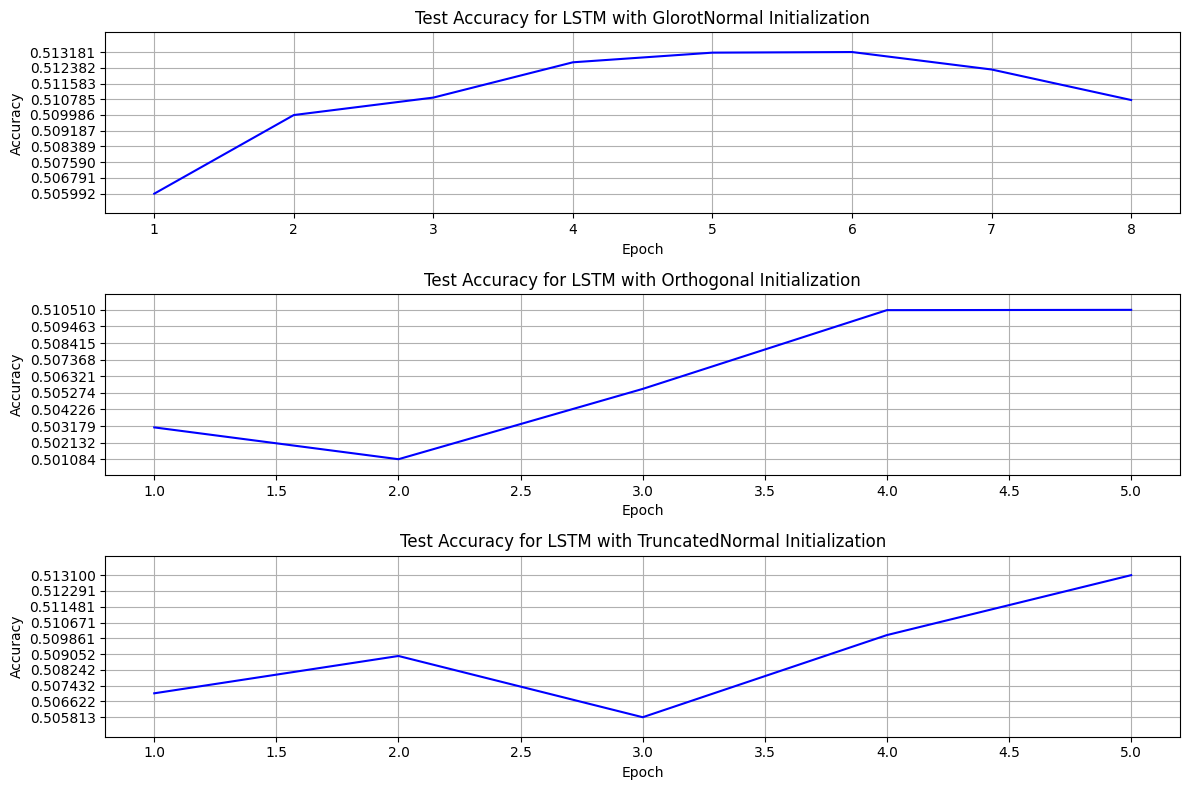

In [246]:
# names of the selected initializers
selected_initializers = ['GlorotNormal', 'Orthogonal', 'TruncatedNormal']

def plot_accuracy_over_time(history_list, initializer_names):
    plt.figure(figsize=(12, 8))
    
    # Plot the validation accuracy for each initializer
    for i, history in enumerate(history_list):
        if initializer_names[i] in selected_initializers:
            accuracy = history.history['accuracy']
            epochs = range(1, len(accuracy) + 1)
            
            # Create subplots
            plt.subplot(3, 1, selected_initializers.index(initializer_names[i]) + 1)
            plt.plot(epochs, accuracy, label=f'Accuracy - {initializer_names[i]}', color='b')
            plt.title(f'Test Accuracy for LSTM with {initializer_names[i]} Initialization')
            plt.xlabel('Epoch')
            plt.ylabel('Accuracy')
            
            # Set y-axis range to show minor variations
            plt.ylim(min(accuracy) - 0.001, max(accuracy) + 0.001)  # Narrow range
            plt.yticks(np.linspace(min(accuracy), max(accuracy), 10)) 
            plt.grid(True)
    
    plt.tight_layout()
    plt.show()

initializer_names = list(initializers.keys())
plot_accuracy_over_time(historyList, initializer_names)


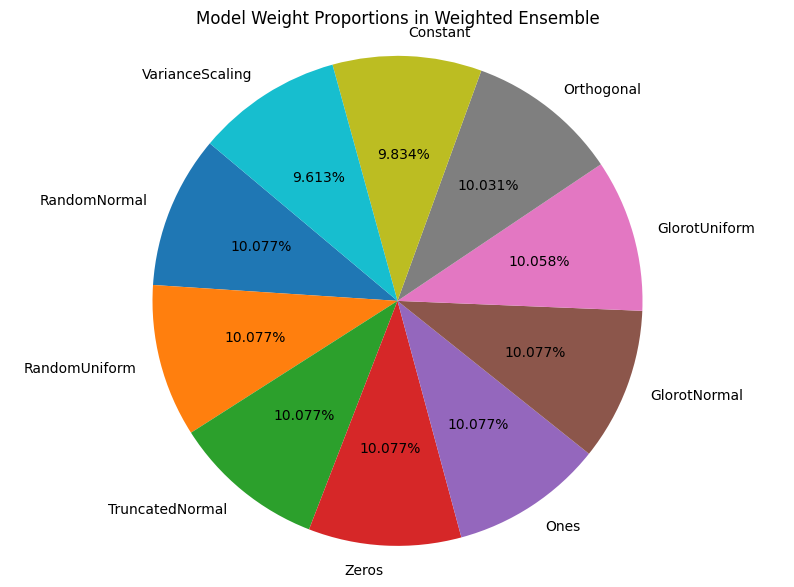

In [248]:
def plot_weighted_ensemble_pie_chart(accuracies, model_names):
    plt.figure(figsize=(10, 7))
    
    # Normalize accuracies to enhance visual differences
    accuracies = [acc * 100 for acc in accuracies]  # Convert to percentage
    
    # Plot pie chart with enhanced detail
    plt.pie(accuracies, labels=model_names, autopct='%1.3f%%', startangle=140) 
    plt.title('Model Weight Proportions in Weighted Ensemble')
    plt.axis('equal')
    plt.show()

model_names = list(initializers.keys())

plot_weighted_ensemble_pie_chart(sorted_accuracies, model_names)


### average training and validation loss Graph

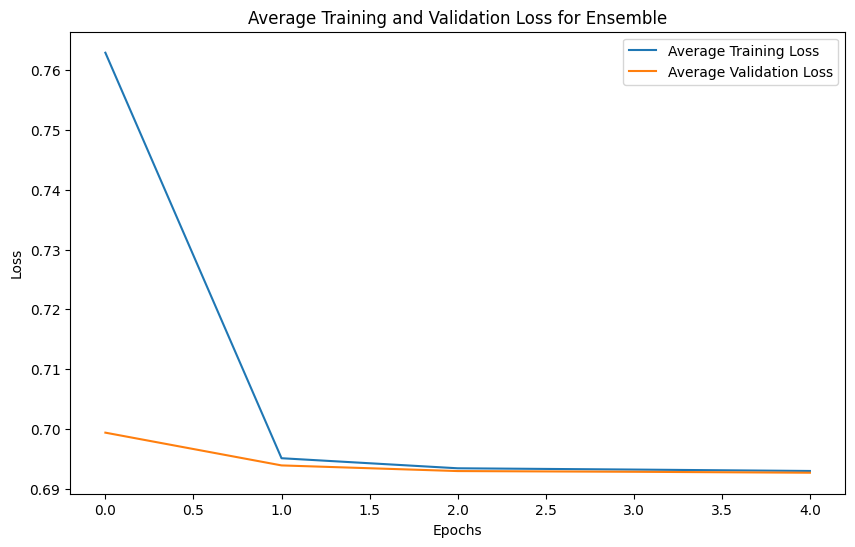

In [250]:
# Define a function to plot the average training and validation loss
def plot_average_loss(history_list):
    # Find the smallest number of epochs across all histories
    min_epochs = min([len(history.history['loss']) for history in history_list])
    
    # Initialize arrays to store total loss
    total_train_loss = np.zeros(min_epochs)
    total_val_loss = np.zeros(min_epochs)

    # Calculate the average training and validation loss for each epoch
    for history in history_list:
        total_train_loss += np.array(history.history['loss'][:min_epochs])
        total_val_loss += np.array(history.history['val_loss'][:min_epochs])

    avg_train_loss = total_train_loss / len(history_list)
    avg_val_loss = total_val_loss / len(history_list)

    # Plot the average training and validation loss curves
    plt.figure(figsize=(10, 6))
    plt.plot(avg_train_loss, label='Average Training Loss')
    plt.plot(avg_val_loss, label='Average Validation Loss')
    plt.title('Average Training and Validation Loss for Ensemble')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Call the function
plot_average_loss(historyList)


In [242]:
# print("First few rows of weighted_preds:\n", weighted_preds[:5])  # 查看前5行

# Portfolio Return

In [243]:
# Process the entire dataset, including both training and test sets
all_data_X = np.concatenate([combined_trainX, combined_testX], axis=0)

# Use the ensemble model to make predictions on the entire dataset
def predict_full_data(models, data, accuracies):
    predictions = np.zeros((data.shape[0], len(models)))
    for i, model in enumerate(models):
        predictions[:, i] = model.predict(data).flatten()
    # Weighted average prediction based on accuracies
    final_prediction = (np.average(predictions, axis=1, weights=accuracies) > 0.488).astype(int)
    return final_prediction

# Get predictions for the full dataset
weighted_preds_full = predict_full_data(sorted_models, all_data_X, sorted_accuracies)


6283/6283 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
6283/6283 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
6283/6283 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
6283/6283 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
6283/6283 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step
6283/6283 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
6283/6283 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step
6283/6283 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step
6283/6283 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step
6283/6283 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step


In [ ]:
all_data_X.shape

In [244]:
# weighted_preds_full.shape
pre = np.array(weighted_preds_full)
# Count occurrences of 0 and 1
count_zeros = np.sum(pre == 0)
count_ones = np.sum(pre == 1)

print(f"Number of 0s: {count_zeros}")
print(f"Number of 1s: {count_ones}")

Number of 0s: 78016
Number of 1s: 123025


Cumulative Return on 1996-02-14 00:00:00: 0.9997888345352497, Prediction index: 29
Cumulative Return on 1996-02-15 00:00:00: 0.9992662433933539, Prediction index: 58
Cumulative Return on 1996-02-16 00:00:00: 0.9999575788018139, Prediction index: 87
Cumulative Return on 1996-02-20 00:00:00: 1.0012966233400094, Prediction index: 116
Cumulative Return on 1996-02-21 00:00:00: 1.0015452487356655, Prediction index: 145
Cumulative Return on 1996-02-22 00:00:00: 1.0025198672387867, Prediction index: 174
Cumulative Return on 1996-02-23 00:00:00: 1.0035301928876719, Prediction index: 203
Cumulative Return on 1996-02-26 00:00:00: 1.0043078507788592, Prediction index: 232
Cumulative Return on 1996-02-27 00:00:00: 1.0050106192937094, Prediction index: 261
Cumulative Return on 1996-02-28 00:00:00: 1.00666643526958, Prediction index: 290
Cumulative Return on 1996-02-29 00:00:00: 1.0081958707125978, Prediction index: 319
Cumulative Return on 1996-03-01 00:00:00: 1.0094800215859294, Prediction index: 3

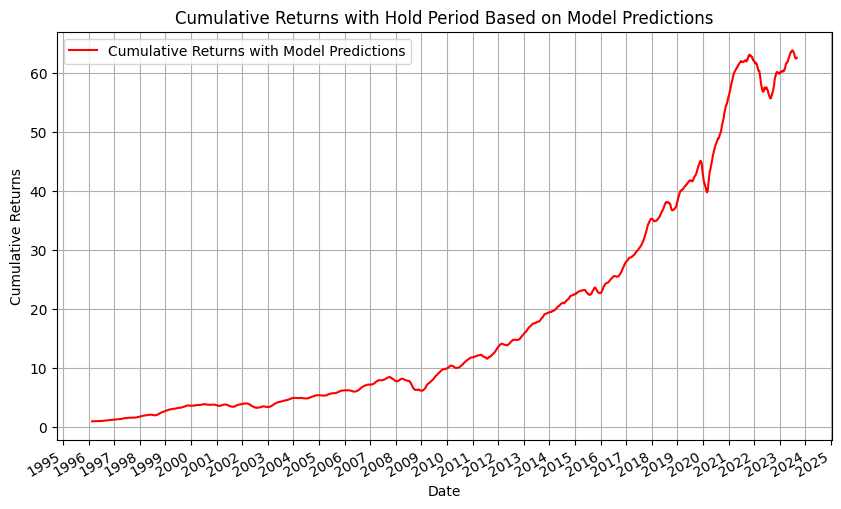

In [252]:
# Calculate cumulative returns based on model predictions weighted_preds_full
def calculate_cumulative_returns_with_model_predictions(df_sequences, weighted_preds_full, stock_columns, look_back, hold_days=10):
    unique_dates = pd.to_datetime(df_sequences['Date']).unique()  
    cumulative_returns = np.zeros(len(unique_dates) - look_back)  # Initialize cumulative returns array, skipping the first look_back days

    pred_index = 0  # To track weighted_preds_full
    
    # Iterate over each date, starting from look_back days
    for i, date in enumerate(unique_dates[look_back:]):
        if pred_index >= len(weighted_preds_full):  # If predictions are exhausted, stop
            print(f"Prediction index {pred_index} out of bounds for {date}. Stopping calculation.")
            break
            
        # Select stocks predicted as 1 based on weighted_preds_full and pred_index
        selected_stocks = []
        for j in range(len(stock_columns)):  # For each of the 29 stocks per day
            if pred_index < len(weighted_preds_full) and weighted_preds_full[pred_index] == 1:  # If model prediction is 1
                selected_stocks.append(stock_columns[j])  # Select the corresponding stock
            pred_index += 1  # Update index after each prediction
            if pred_index >= len(weighted_preds_full):
                break
        
        # Skip calculation if not enough future dates to hold
        if i + hold_days >= len(unique_dates) - look_back:
            print(f"Not enough future dates for {date}. Skipping calculation.")
            continue
    
        # Check if there are selected stocks
        if len(selected_stocks) > 0:
            # Get actual returns for these stocks over the hold_days period
            future_dates = unique_dates[i+look_back:i+look_back+hold_days]  # Get dates for the future hold_days
            future_returns = df_sequences[df_sequences['Date'].isin(future_dates)][selected_stocks].values
            
            # Skip stocks with NaN returns
            if not np.isnan(future_returns).all():
                # Calculate average return for the selected stocks over the holding period
                valid_returns = future_returns[~np.isnan(future_returns)]  # Filter out NaNs
                portfolio_return = np.mean(valid_returns) if len(valid_returns) > 0 else 0
            else:
                portfolio_return = 0  # Skip if all stock data are NaN
        else:
            portfolio_return = 0  # If no stocks selected, return is 0
     
        # Ensure cumulative return is not NaN, set to 0
        if np.isnan(portfolio_return):
            portfolio_return = 0
            
        # Ensure cumulative return is not 0
        prev_cumulative_return = cumulative_returns[i-1] if i > 0 else 1
        if prev_cumulative_return == 0:
            prev_cumulative_return = 1

        # Calculate cumulative return as the product of (1 + daily return)
        cumulative_returns[i] = (1 + portfolio_return) * prev_cumulative_return

        # Debug print: output cumulative returns and index status
        print(f"Cumulative Return on {date}: {cumulative_returns[i]}, Prediction index: {pred_index}")
    
    return cumulative_returns[:len(unique_dates) - look_back]

# Extract stock columns (return columns), excluding 'Date' and columns starting with 'label_'
stock_columns = [col for col in df_filtered.columns if col not in ['Date'] and not col.startswith('label_') and col != 'Median']

look_back = 30
cumulative_returns = calculate_cumulative_returns_with_model_predictions(df_filtered, weighted_preds_full, stock_columns, look_back=look_back, hold_days=60)

# Get all unique dates, starting from the look_back days, filtering out periods without sufficient holding days
unique_dates = pd.to_datetime(df_filtered['Date']).unique()[look_back:][:len(cumulative_returns)]

# Define function to plot cumulative returns
def plot_cumulative_returns(cumulative_returns, dates):
    plt.figure(figsize=(10, 6))
    
    # Plot only non-zero and greater than 1 cumulative returns to avoid plotting invalid zero values
    valid_indices = np.where(cumulative_returns > 1)[0]  # Find indices with valid returns
    valid_cumulative_returns = cumulative_returns[valid_indices]
    valid_dates = dates[valid_indices]

    # Plot valid cumulative returns
    plt.plot(valid_dates, valid_cumulative_returns, label='Cumulative Returns with Model Predictions', color='r')
    
    # Set title and labels
    plt.title('Cumulative Returns with Hold Period Based on Model Predictions')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Mark every year
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Display year
    plt.gcf().autofmt_xdate()
    plt.grid(True)
    plt.show()

# Call the plotting function to display cumulative returns for valid range
plot_cumulative_returns(cumulative_returns, unique_dates)